In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
from xgboost import XGBRegressor

pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

# define problem
- as a company with tight financial. The company wants to provide health-mental wellness program and health examination program for employees that TENDS to absent. But it is hard for the company to indentify which employees that needs to be treated in the program. 

# Goals
- Identifying the employee that TENDS to absent
- find the factors based on the data that affecting the healthiness of employee
- the manager is ready enough to handle if their employee are tends go absent

In [3]:
df = pd.read_csv('Absenteeism.csv', sep = ';')

In [4]:
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,8
736,1,11,7,3,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,4
737,4,0,0,3,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0


# Data checking

In [5]:
df['Absenteeism time in hours'].unique()

array([  4,   0,   2,   8,  40,   1,   7,   3,  32,   5,  16,  24,  64,
        56,  80, 120, 112, 104,  48], dtype=int64)

In [6]:
bsDesc = []

for i in df.columns:
    bsDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])
pd.DataFrame(data = bsDesc,
            columns = [
                'Features',
                'DataType',
                'Null',
                'NullPercentage',
                'Unique',
                'Unique Sample'
            ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,ID,int64,0,0.0,36,"[27, 20]"
1,Reason for absence,int64,0,0.0,28,"[8, 17]"
2,Month of absence,int64,0,0.0,13,"[12, 4]"
3,Day of the week,int64,0,0.0,5,"[4, 5]"
4,Seasons,int64,0,0.0,4,"[4, 1]"
5,Transportation expense,int64,0,0.0,24,"[155, 248]"
6,Distance from Residence to Work,int64,0,0.0,25,"[5, 27]"
7,Service time,int64,0,0.0,18,"[13, 10]"
8,Age,int64,0,0.0,22,"[41, 50]"
9,Work load Average/day,float64,0,0.0,38,"[253.957, 236.62900000000002]"


In [7]:
df.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,18.017568,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,11.021247,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


Data is clean (no missing value)

In [8]:
df.dtypes

ID                                   int64
Reason for absence                   int64
Month of absence                     int64
Day of the week                      int64
Seasons                              int64
Transportation expense               int64
Distance from Residence to Work      int64
Service time                         int64
Age                                  int64
Work load Average/day              float64
Hit target                           int64
Disciplinary failure                 int64
Education                            int64
Son                                  int64
Social drinker                       int64
Social smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body mass index                      int64
Absenteeism time in hours            int64
dtype: object

all rows are numeric value.

In [9]:
df.drop(columns = 'ID', inplace = True)

In [10]:
df

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,14,7,3,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,8
736,11,7,3,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,4
737,0,0,3,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0
738,0,0,4,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0


In [11]:
outliers = []
def outlier_check(data):
    sorted(data)
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    for i in data:
        if i < lower_fence or i > upper_fence:
            outliers.append(i)
    return outliers

In [12]:
outliers = []
len(outlier_check(df['Age']))

8

In [13]:
df_outlierage = df[df['Age'].isin(outliers)]
df_outlierage

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
255,18,8,3,1,228,14,16,58,265.615,94,0,1,2,0,0,1,65,172,22,8
434,18,5,4,3,228,14,16,58,246.074,99,0,1,2,0,0,1,65,172,22,8
521,1,10,4,4,228,14,16,58,284.853,91,0,1,2,0,0,1,65,172,22,1
620,25,3,3,2,228,14,16,58,222.196,99,0,1,2,0,0,1,65,172,22,3
622,12,3,3,2,228,14,16,58,222.196,99,0,1,2,0,0,1,65,172,22,112
640,25,3,4,2,228,14,16,58,222.196,99,0,1,2,0,0,1,65,172,22,2
727,6,7,2,1,228,14,16,58,264.604,93,0,1,2,0,0,1,65,172,22,8
729,6,7,3,1,228,14,16,58,264.604,93,0,1,2,0,0,1,65,172,22,120


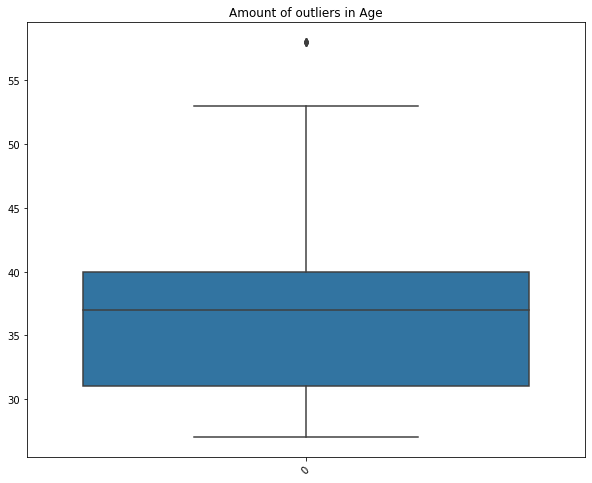

In [14]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df['Age'])
plt.title("Amount of outliers in Age")
plt.xticks(rotation=45)
plt.show()

There are 8 outliers in age column -> data with age of 58 but it is still reasonable so we do not drop the outliers

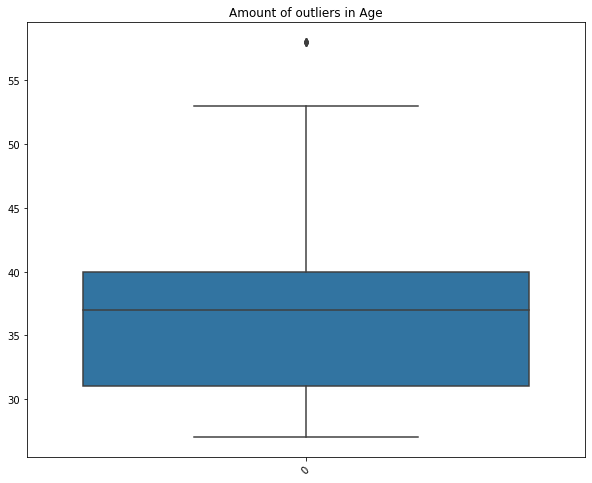

In [15]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df['Age'])
plt.title("Amount of outliers in Age")
plt.xticks(rotation=45)
plt.show()

- data is clean
- no missing value
- all rows are numeric values
- data target is absenteeism time in hours -> continous numeric -> later on we will change into 1 ( absent) and 0 (not absent) for machine learning purposes.
- based on df.describe() data is well prepared, the min and max value is according to its description. And there are no outliers that we need to drop

# Analysis

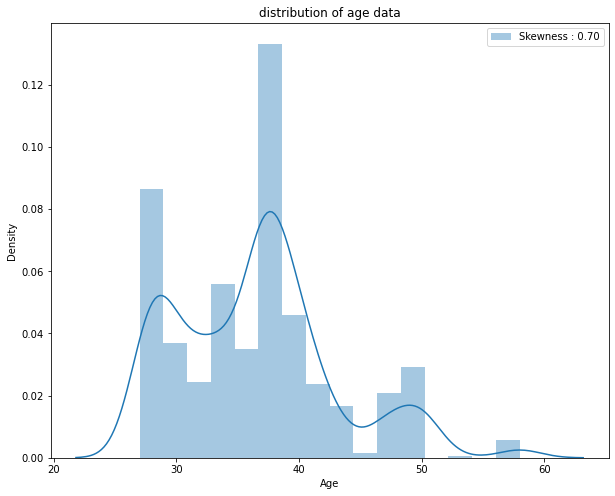

In [16]:
plt.figure(figsize = (10,8))
sns.distplot(df['Age'],label = 'Skewness : %.2f'%(df['Age'].skew()))
plt.title('distribution of age data')
plt.legend()

plt.plot()
plt.show()

The distribution of age is moderately skewed with skewness score = 0.7. Also positive skew which means that the mode is  smaller than the median or mean. Based on the data the majority of employee's age is around 20 to 60. 

In [17]:
mean_reason = df[['Reason for absence', 'Absenteeism time in hours']].groupby('Reason for absence').mean().reset_index().sort_values('Absenteeism time in hours', ascending = False)

In [18]:
mean_reason

,Reason for absence,Absenteeism time in hours
9,9,42.000000
2,2,24.000000
12,12,23.375000
6,6,21.375000
19,19,18.225000
13,13,15.309091
11,11,11.423077
1,1,11.375000
10,10,11.040000
18,18,10.333333


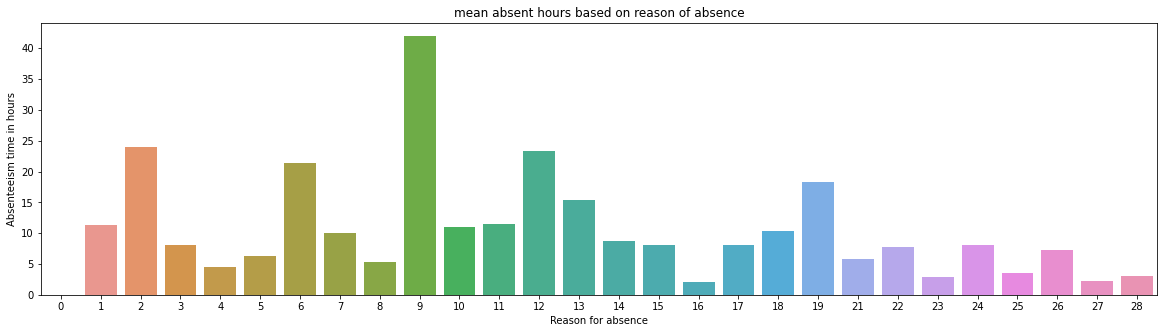

In [19]:
plt.figure(figsize = (20,5))
sns.barplot(mean_reason['Reason for absence'],   mean_reason['Absenteeism time in hours'])
plt.title('mean absent hours based on reason of absence')
plt.show()

The highest mean hours of absensce is because of disease of circulatory system. It is related to heart disease, based on the data heart disease took longer time to recover, it is 18 hours longer than the top 2 absent reason which is neoplasm 

In [20]:
reason_counts = df[['Reason for absence', 'Absenteeism time in hours']].groupby('Reason for absence').count().reset_index().sort_values('Absenteeism time in hours', ascending = False)
reason_counts.columns = ['Reason for absence', 'Absenteeism count']
reason_counts

,Reason for absence,Absenteeism count
22,23,149
27,28,112
26,27,69
13,13,55
0,0,43
19,19,40
21,22,38
25,26,33
24,25,31
11,11,26


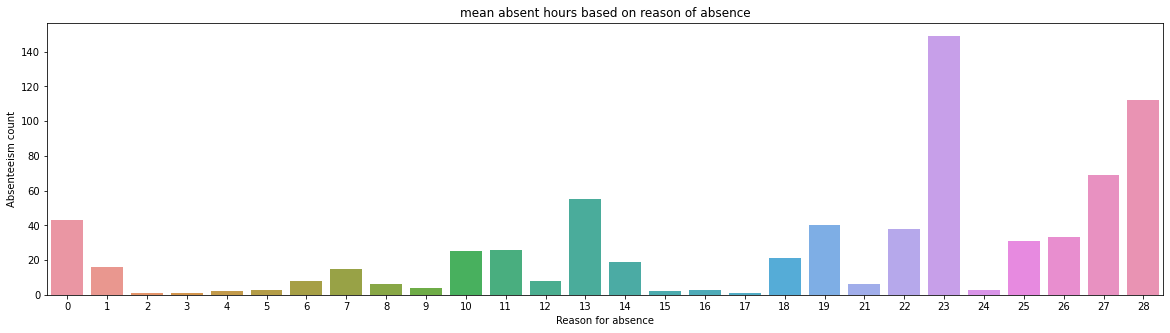

In [21]:
plt.figure(figsize = (20,5))
sns.barplot(reason_counts['Reason for absence'],   reason_counts['Absenteeism count'])
plt.title('mean absent hours based on reason of absence')
plt.show()

blood donation has the highest number of employee that absent, followed by dental consultation, physioteraphy, and musculoskeletal system. Well the employee is really care about humanity lots of them donates blood. Blood donation average hour absence is 2.8 hours per employee it is relatively low (ranked 4 from bottom of mean absence hours) it does not contribute much to the absent hours of employee per employee. if the duration of the absence is short, the work can still be done without disturbing the timeline of the project. But if the duration is high then the employee needs to find someone as a backup or the backup person might do 2 task in the same time which is leading to more stressed to the backup employee. So health is really a concern to maintain productivity of employee.

Unjustified reason needs to be more specific because the number mean hours of absentees is 6.3 (higher than the median).

In [22]:
reason_sum = df[['Reason for absence', 'Absenteeism time in hours']].groupby('Reason for absence').sum().reset_index().sort_values('Absenteeism time in hours', ascending = False)
reason_sum.columns = ['Reason for absence', 'Total numbers of hours']


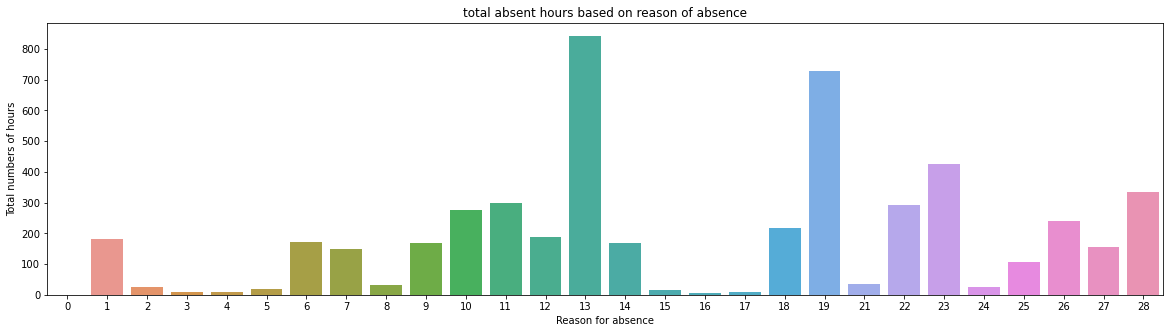

In [23]:
plt.figure(figsize = (20,5))
sns.barplot(reason_sum['Reason for absence'],   reason_sum['Total numbers of hours'])
plt.title('total absent hours based on reason of absence')
plt.show()

top 3 total number of hours :
- Diseases of the musculoskeletal system and connective tissue  
  because of limitation of data (we dont know that type of this company is) so basec on the disease we assume that lots of the company are manual labour (hard worker) that use its muscle to work. it leads to the highest hours of absent. 
- Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified  
- medical consultation
  medical consultation is common in reason of abscenses in company.

In [24]:
bd_mass = df[['Reason for absence', 'Body mass index']].groupby('Reason for absence').mean().reset_index().sort_values('Body mass index', ascending = False)

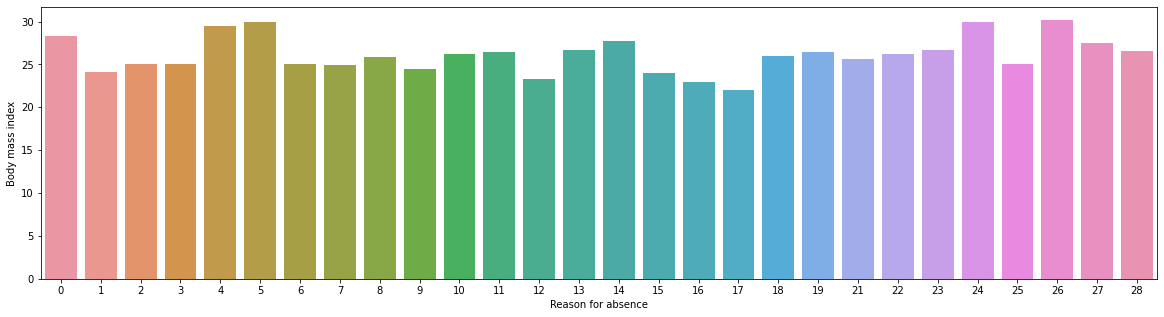

In [25]:
plt.figure(figsize = (20,5))
sns.barplot(x = bd_mass['Reason for absence'], y = bd_mass['Body mass index'])
plt.show()

Underweight = <18.5
Normal weight = 18.5–24.9
Overweight = 25–29.9
Obesity = BMI of 30 or greater
- the mean body mass index in the company is 26.6 -> overweight


based on the data, obesity employees (bmi >= 30) has reason of absence :
- unjustified reason
- mental and behavioral disorder
- blood donation
- surprisingly, the person that donates blood came from obesity person. based on article ,there is no upper weight limit as long as your weight is not higher than the weight limit of the donor bed or lounge you are using.
- well unjustified reason needs to be describe more specificly to know that does obesity leads to serious problem.
- mental and behavioral disorder are from obese person -> company needs to provide mental wellness care
- surprisingly the person who are healthy (no absent) are from overweight class. As long as the person can maintain its healthy-life balance they has lower probability of sickness


In [26]:
month = df[['Month of absence', 'Absenteeism time in hours']].groupby('Month of absence').sum().reset_index()

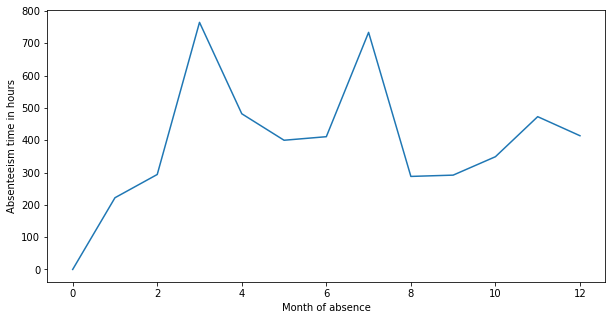

In [27]:
plt.figure(figsize = (10,5))
sns.lineplot(x = month['Month of absence'], y= month['Absenteeism time in hours'])
plt.show()

In march and july employee tends to go absent. Company should take a step to lower the number of absentees in this month. Higher hours of absentees can leads to lower productivity to the company. 

In [28]:
day = df[['Day of the week', 'Absenteeism time in hours']].groupby('Day of the week').sum().reset_index()
day

,Day of the week,Absenteeism time in hours
0,2,1489
1,3,1229
2,4,1115
3,5,553
4,6,738


[]

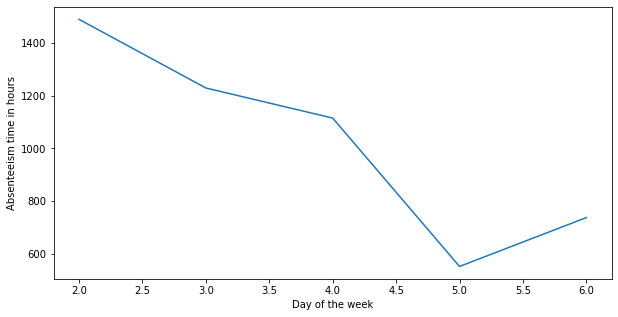

In [29]:
plt.figure(figsize = (10,5))
sns.lineplot(x = day['Day of the week'], y= day['Absenteeism time in hours'])
plt.plot()

There were no data that recorded on monday (0 records).
- The more closer to weekend, the lower the total absenteeism hours

In [30]:
season = df[['Seasons', 'Absenteeism time in hours']].groupby('Seasons').sum().reset_index()
season

,Seasons,Absenteeism time in hours
0,1,1241
1,2,1152
2,3,1492
3,4,1239


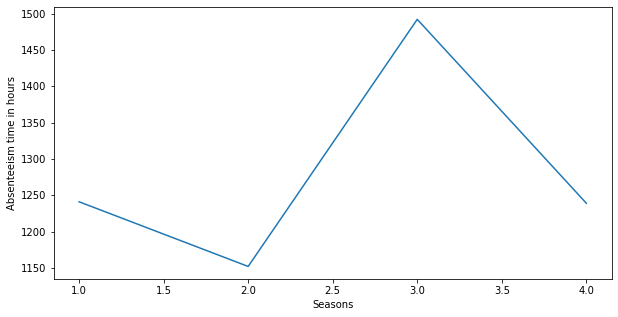

In [31]:
plt.figure(figsize = (10,5))
sns.lineplot(x = season['Seasons'], y = season['Absenteeism time in hours'])
plt.show()

Despite having the highest total hours of absence in march, if we see from the graphy above. Season 1 (Q1) from jaunary to march is not the highest total hours of absence.
The highest is from season s3(Q3) from july to september. 

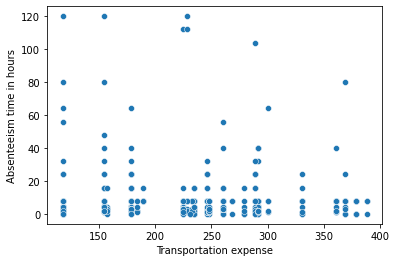

In [32]:
sns.scatterplot(df['Transportation expense'], df['Absenteeism time in hours'])
plt.show()

If we take a look at the scatter plot, the were no linear relationship between transporation expense and absenteeism time in hours

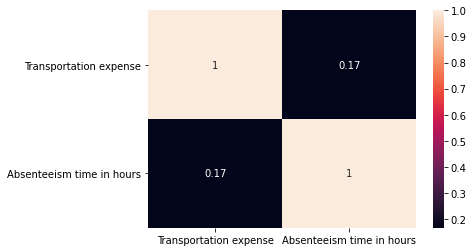

In [33]:
sns.heatmap(df[['Transportation expense', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

Based on confusion matrix, there are positive correlation but the number is quite low (weak correlation).

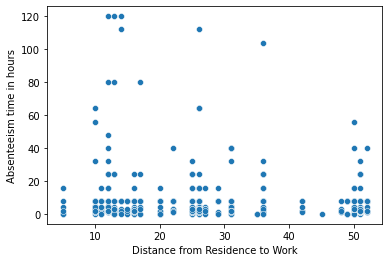

In [34]:
sns.scatterplot(df['Distance from Residence to Work'], df['Absenteeism time in hours'])
plt.show()

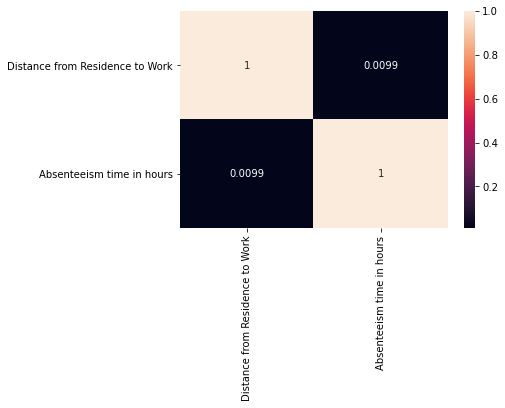

In [35]:
sns.heatmap(df[['Distance from Residence to Work', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

- If we take a look at the scatter plot, the were no  linear relationship between distance and absenteeism time in hours. Based on confusion matrix, there are positive correlation but the number is indicating that it is very weak because the number is very close to 0. We could conclude that distance is not the factors that made the employee absent.

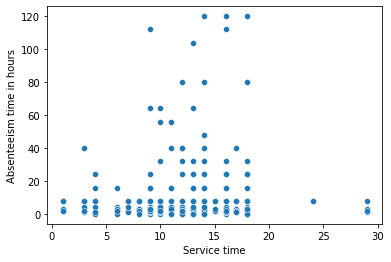

In [36]:
sns.scatterplot(df['Service time'], df['Absenteeism time in hours'])
plt.show()

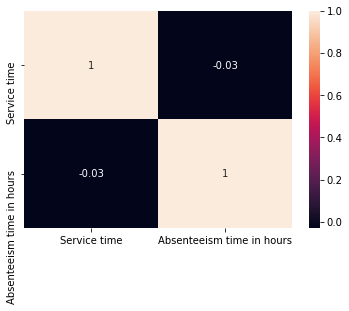

In [37]:
sns.heatmap(df[['Service time', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

- If we take a look at the scatter plot, the were no  linear relationship between service time and absenteeism time in hours. Based on confusion matrix, there are negative correlation but the number is indicating that it is very weak because the number is very close to 0. We could conclude that service time  is not the factors that made the employee absent.

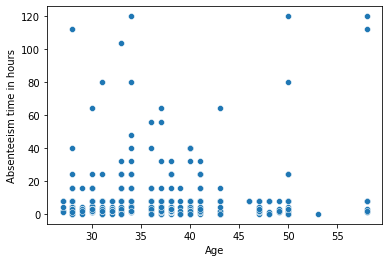

In [38]:
sns.scatterplot(df['Age'], df['Absenteeism time in hours'])
plt.show()

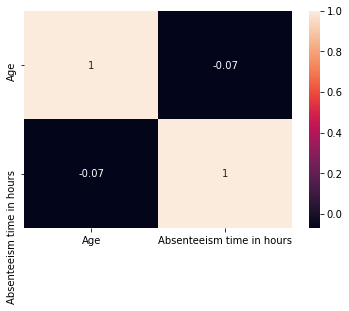

In [39]:
sns.heatmap(df[['Age', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

- If we take a look at the scatter plot, the were no  linear relationship between age and absenteeism time in hours. Based on confusion matrix, there are negative correlation but the number is indicating that it is very weak because the number is very close to 0. We could conclude that age is not the factors that made the employee absent. Employee that is on its senior age does not mean that they are more prone to sickness, also employee that are still young does not mean they're healthy.

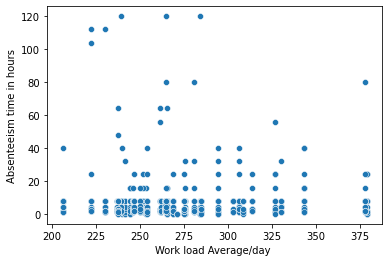

In [40]:
sns.scatterplot(df['Work load Average/day '], df['Absenteeism time in hours'])
plt.show()

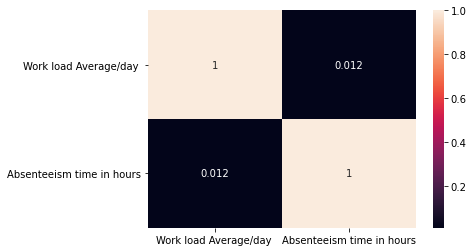

In [41]:
sns.heatmap(df[['Work load Average/day ', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

- If we take a look at the scatter plot, the were no  linear relationship between workload and absenteeism time in hours. Based on confusion matrix, there are positive correlation but the number is indicating that it is very weak because the number is very close to 0. We could conclude that workload is not the factors that made the employee absent. Usually higher workload leads to more stress for the employee, but based on this data higher workload does not affecting their mental health. 

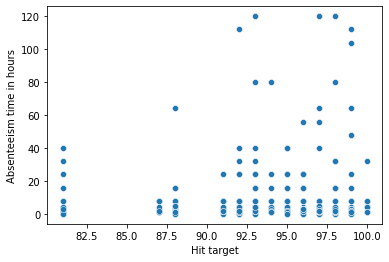

In [42]:
sns.scatterplot(df['Hit target'], df['Absenteeism time in hours'])
plt.show()

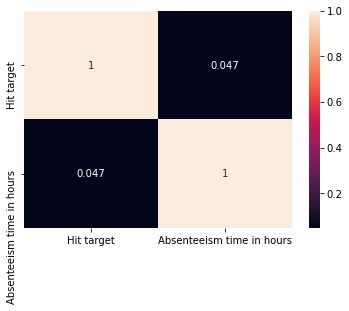

In [43]:
sns.heatmap(df[['Hit target', 'Absenteeism time in hours']].corr('spearman'), annot = True)
plt.show()

- If we take a look at the scatter plot, the were no  linear relationship between Hit target and absenteeism time in hours. Based on confusion matrix, there are positive correlation but the number is indicating that it is very weak because the number is very close to 0. We could conclude that hit target is not the factors that made the employee absent.

In [44]:
df[['Disciplinary failure', 'Absenteeism time in hours']].groupby('Disciplinary failure').sum()

,Absenteeism time in hours
Disciplinary failure,
0,5124
1,0


- The employee that are absent does not because of indisciplinary action
- the indisiciplinary action is not because of they are absent with no reason. but it is more indiciplinary action in work environment

In [45]:
df[['Education', 'Absenteeism time in hours']].groupby('Education').count()

,Absenteeism time in hours
Education,
1,611
2,46
3,79
4,4


In [46]:
edu= df[['Education', 'Absenteeism time in hours']].groupby('Education').sum().reset_index()

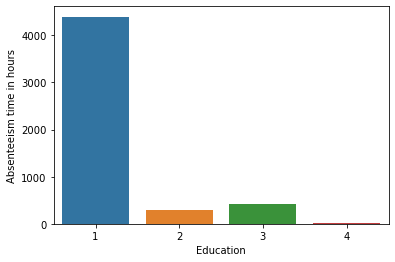

In [47]:
sns.barplot(edu['Education'], edu['Absenteeism time in hours'])
plt.show()

In [48]:
correlation_ratio(df['Education'], df['Absenteeism time in hours'])

0.046556355048712535

- the majority education of employee is on highschool level and the majority of absenteeism are from high-school education - employee.
- based on correlation ratio, higher education does not mean they are healthier.

In [49]:
son= df[['Son', 'Absenteeism time in hours']].groupby('Son').sum().reset_index()

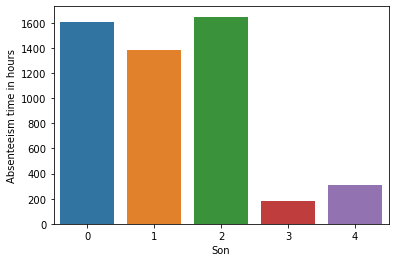

In [50]:
sns.barplot(son['Son'], son['Absenteeism time in hours'])
plt.show()

In [51]:
df[['Son', 'Absenteeism time in hours']].corr('spearman')

,Son,Absenteeism time in hours
Son,1.000000,0.150154
Absenteeism time in hours,0.150154,1.000000


- surprisingly, the more number of son they have the less hours they are absence
- based on correlation ratio, more son does not affecting absence hours.

In [52]:
drink= df[['Social drinker', 'Absenteeism time in hours']].groupby('Social drinker').sum().reset_index()

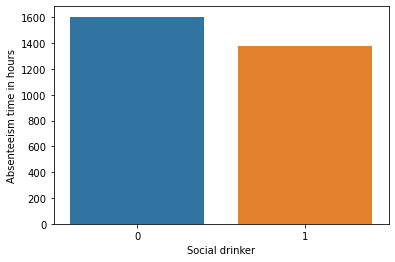

In [53]:
sns.barplot(drink['Social drinker'], son['Absenteeism time in hours'])
plt.show()

- Social drinker category leads to more absenteism time in hours

In [54]:
smoke= df[['Social smoker', 'Absenteeism time in hours']].groupby('Social smoker').sum().reset_index()

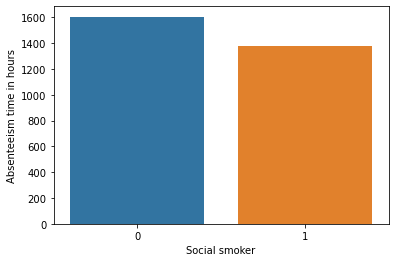

In [55]:
sns.barplot(smoke['Social smoker'], son['Absenteeism time in hours'])
plt.show()

In [56]:
correlation_ratio(df['Social smoker'], df['Absenteeism time in hours'])

0.008936423141141138

- surprisingly smoking does not leads to more absenteeism
- based on correlation ratio, smoking does not affecting the hours of absenteeism

In [57]:
df['Social smoker'].value_counts()

0    686
1     54
Name: Social smoker, dtype: int64

In [58]:
pet= df[['Pet', 'Absenteeism time in hours']].groupby('Pet').sum().reset_index()

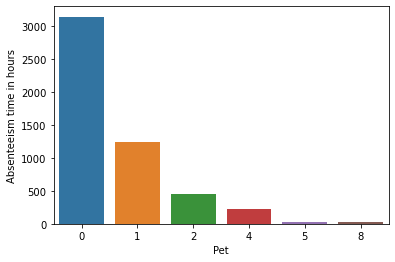

In [59]:
sns.barplot(pet['Pet'], pet['Absenteeism time in hours'])
plt.show()

- based on the data, employee that have pet are having less in absenteeism time in hours. Having a pet its one of source of hapiness for some person, it could boost immunity if the person is happy.

In [60]:
bmi= df[['Body mass index', 'Absenteeism time in hours']].groupby('Body mass index').sum().reset_index()

[]

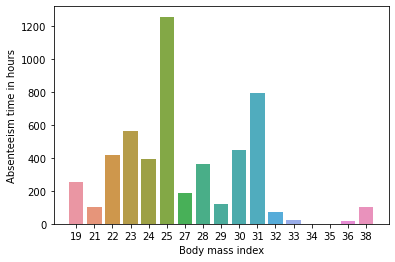

In [61]:
sns.barplot(bmi['Body mass index'], bmi['Absenteeism time in hours'])
plt.plot()

In [62]:
df[['Body mass index', 'Absenteeism time in hours']].corr('spearman')

,Body mass index,Absenteeism time in hours
Body mass index,1.000000,-0.062574
Absenteeism time in hours,-0.062574,1.000000


# Conclusion & recommendation
- bmi does not affecting to absenteesim time in hours based on the barplot and correlation (-0.06)
- based on the data, employee that have pet are having less in absenteeism time in hours. Having a pet its one of source of hapiness for some person, it could boost immunity if the person is happy.
- surprisingly smoking does not leads to more absenteeism 
- Social drinker category leads to more absenteism time in hours
- surprisingly, the more number of son they have the less hours they are absence. based on correlation ratio, more son does not affecting absence hours.
- the majority education of employee is on highschool level and the majority of absenteeism are from high-school education - employee. based on correlation ratio, higher education does not mean they are healthier.
- The employee that are absent does not because of indisciplinary action
- the indisiciplinary action is not because of they are absent with no reason. but it is more indiciplinary action in work environment
-  We could conclude that hit target is not the factors that made the employee absent.
-  We could conclude that workload is not the factors that made the employee absent. Usually higher workload leads to more stress for the employee, but based on this data higher workload does not affecting their mental health. 
- We could conclude that age is not the factors that made the employee absent. Employee that is on its senior age does not mean that they are more prone to sickness, also employee that are still young does not mean they're healthy.
- We could conclude that service time  is not the factors that made the employee absent
- We could conclude that distance is not the factors that made the employee absent.
- If we take a look at the scatter plot, the were no linear relationship between transporation expense and absenteeism time in hours, weak correlation
- Despite having the highest total hours of absence in march, if we see from the graph above. Season 1 (Q1) from jaunary to march is not the highest total hours of absence.The highest is from season s3(Q3) from july to september.
- The more closer to weekend, the lower the total absenteeism hours
- In march and july employee tends to go absence. Company should take a step to lower the number of absentees in this month. Higher hours of absentees can leads to lower productivity to the company. 
- The highest mean hours of absensce is because of disease of circulatory system. It is related to heart disease, based on the data heart disease took longer time to recover, it is 18 hours longer than the top 2 absent reason which is neoplasm 
- blood donation has the highest number of employee that absent, followed by dental consultation, physioteraphy, and musculoskeletal system. Well the employee is really care about humanity lots of them donates blood. Blood donation average hour absence is 2.8 hours per employee it is relatively low (ranked 4 from bottom of mean absence hours) it does not contribute much to the absent hours of employee per employee. if the duration of the absence is short, the work can still be done without disturbing the timeline of the project. But if the duration is high then the employee needs to find someone as a backup or the backup person might do 2 task in the same time which is leading to more stressed to the backup employee. So health is really a concern to maintain productivity of employee.
- Unjustified reason needs to be more specific because the number mean hours of absentees is 6.3 (higher than the median).

based on the data, obesity employees (bmi >= 30) has reason of absence :
- unjustified reason
- mental and behavioral disorder
- blood donation
- surprisingly, the person that donates blood came from obesity person. based on article ,there is no upper weight limit as long as your weight is not higher than the weight limit of the donor bed or lounge you are using.
- well unjustified reason needs to be describe more specificly to know that does obesity leads to serious problem.
- mental and behavioral disorder are from obese person -> company needs to provide mental wellness care
- surprisingly the person who are healthy (no absent) are from overweight class. As long as the person can maintain its healthy-life balance they has lower probability of sickness

# Machine learning conclusion
Minority = not absent
majority = absent
1 = absent (not present)
0 = not absent (present)
True positive = Actual absent, prediction absent
True negative = Actual not absent, prediction not absent
False positive =  Aktualnya tidak absen (masuk), tapi diprediksi absen (tidak masuk)
False negative = Aktual nya dia absen (tidak masuk) tapi prediksi nya ga absen (masuk) -> main concern 

MAIN CONCERN
- our main concern is to supress the number of false negative while also having least number of false positive. (balancing)
- Why we want to balance out the false positive and false negative. 
  Case:
  After detecting the employee that tends to go sick. the company apporach is to examine the employees health to mental-wellness-program and healthy-program. Also taking several health examination. If we have big false positive then company have to pay more for the program and examination (more people that detected tends to go absent but the actual he is healthy). Also we need to supress the false negative so that our prediction is more likely to be accurate in predicting people that tends to go absent.
  
Because the data is imbalance so we focus on tuning the minority class which is 0 (not absent) to get more accurate prediction


- The recall score for base model is already high, so we do not need to do imbalance data handling
- the best algoritm for this classification problem is using randomforest algoritm with area under the curve (AUC = 0.95) and recall score 0.85
- the recall score random forest before tuned and after tuned is the same also the AUC score
- tuning does not improve the model recall score
I recommend the company to gather more health data about the employee such as (glucose level, cholestrol, uric acid, blood pressure and so on) and the data needs to be updated every terms. So that it gave more accurate readings of the prediction. Healthy employee leads to increase in productivity and low absenteeism.

Handling people that tends to go absent 
- mental wellness program
- health care program
- health examination

Assumption
- cost of medical program per employee = 10 USD
- if we provide medical program for all employee : 740 * 10 USD = 7400 USD
- if we use machine learning as the predictor, the company just pay based on the prediction (not paying for all employee)
- For example : using machine learning it predicts that there are 120 people tends to go absent.
    120 x 10 USd = 1200 USD
    7400 -1200  = 6200 USD -> SAVED.

- in longrun it will increase the productivity
